#Example calculation of the ground state of Bose-Hubbard model




In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
# including necessary files and latex fonts
!cp drive/MyDrive/DNN/HubbardNet_gpu.py .
!cp drive/MyDrive/DNN/matrix_element.py .
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install matplotlib==3.2.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import time 
import torch
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import numpy as np

from HubbardNet_gpu import *
import matrix_element as me

from os import path
import os
from copy import copy


In [30]:
# Go to Edit -> Notebook Settings and select "GPU" from the hardware accelerator dropdown. 
# If this is on, GPU is enabled by default

use_gpu = True

# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available() and use_gpu:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('Using GPU.')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')

    if not torch.cuda.is_available() and use_gpu: 
        use_gpu = False 
        print('GPU not available. Using CPU.')
    else: 
        print('Using CPU.')


Using GPU.


In [31]:
N_list = [5]
N = N_list[0]
model_list = []

M = 6
w = M
h = int(M/w)
pbc = True

for (n_idx, N) in enumerate(N_list): 
    O = N
    
    model = me.Bose_Hubbard(N, O, w=w, h=h, M=M, pbc=pbc)
    model_list.append(model)
    
print("The size of the Hamiltonian is {}".format(model.tot_states))

t = 1 
U_max = 5
V = 0
U_list_all = np.arange(1, U_max+1, .5)
mu_list_all = np.linspace(0, 10, 5)
mu_list_all = np.array([0.])


The size of the Hamiltonian is 252


In [32]:
from tqdm import tqdm

## NN

S = 50 # number of sample of the MH sampler (not used)
init = 1 # the first state to sample in Metropolis Hastings (has nothing to do with the optimizer!) (not used)

# Network parameters
D_hid = 400 # the number ofneurons in the hidden layer
lr = 0.01 # learning rate 
epochs = 70000
loss_diff = 1e-7
grad_cut = 1e-6
check_point = 100 # print out the energy every X points
use_sampler = False # for now, only support ground state (not working anyway)

# Model parameters
U_train = np.ones(3)*2
t_train = 1.

U_train = np.array([2., 6, 9])
mu_train = np.zeros_like(U_train)

min_state = 0
max_state = 1

n_excited = max_state - 1

# paths to save and load weights 
fpath = '/content/drive/MyDrive/DNN/weights/'

t0 = time.time()

loss_all = [] 
penalty_all = []
nn = []

# filepath for excited states
fname = fpath + "/weights_M{}N{}_V{}_Umax{}_Umin{}_L5_D{}".format(M,N,V,np.max(U_train),np.min(U_train),D_hid)


In [33]:
def call_NN(lr, n_excited):
    if n_excited: 
        if n_excited == 1 :
            load_states_indv = [0]
        else:
            load_states_indv = range(1, n_excited)
        gs_flag = False
        es_flag = True

    else: # ground states
        load_states_indv = [0]
        gs_flag = True
        es_flag = False
    
    load_states = np.max(load_states_indv)  # total number of states being fixed 
  
    params = {'D_hid': D_hid, 
              'step_size': lr, 
              'max_iteration':epochs,
              'check_point': check_point,
              'loss_diff': loss_diff, 
              'steps': 1000, # reset learning every N steps
              'loss_check_steps': 50, # check the local every N steps
              'grad_cut': grad_cut,  # stopping condition in the total gradient 
              'weight_init': False, 
              'zero_bias': False, 
              'gs_epochs': 1000, # the maximum number of steps to minimize the ground state
              'gs_flag': gs_flag, # ground state only
              'es_flag': es_flag,  # excited state only
              'regularization': True, 
              'load_states': load_states, # the number of states loaded 
              'load_states_indv': load_states_indv, 
              'rand_steps': 5000, 
              'load_weights_from_previous_state': False, # randomize the projection every N steps
              'use_gpu': use_gpu, 
              'weight_decay': 0,
              'perturb_amp': 0.00, 
              'dropout': 0.0}
  
    print("Begin optimizing for state {}".format(n_excited))

    fc1, Loss_history, dot_history, all_E_list = train_NN(model_list, N_list, mu_train, U_train, t_train, V, S, params, fname, \
                                            use_sampler=use_sampler, init=init, loadweights=False,\
                                            fname_load=fname, n_excited=n_excited)

    return fc1, Loss_history, dot_history



for n_excited in range(min_state, max_state):
    
    fc1, Loss_history, dot_history = call_NN(lr, n_excited)

    nn.append(fc1)
    loss_all.append(Loss_history)
    penalty_all.append(dot_history)
    
tf = time.time()
print("Training time = {} seconds.".format(tf-t0))

Begin optimizing for state 0
0.0


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration 0, current learning rate 0.01, loss 6.951722621917725, total gradient 1.4352076665407372
Iteration 100, current learning rate 0.00975045441899919, loss -1.9338749647140503, total gradient 49.62581008698872
Iteration 200, current learning rate 0.0090358814139336, loss -5.43880033493042, total gradient -1.5234958217484689
Iteration 300, current learning rate 0.007926253039256266, loss -5.547769546508789, total gradient 0.06847068500938851
Iteration 400, current learning rate 0.006530187446508231, loss -5.558007717132568, total gradient 0.03600808341897057
Iteration 500, current learning rate 0.004984341255885153, loss -5.561036586761475, total gradient 0.017120593889101206
Iteration 600, current learning rate 0.0034400326517927465, loss -5.56239128112793, total gradient 0.00910590315134575
Iteration 700, current learning rate 0.002048429298162418, loss -5.563054084777832, total gradient 0.006126409510048667
Iteration 800, current learning rate 0.0009457509696090279, loss -5.563

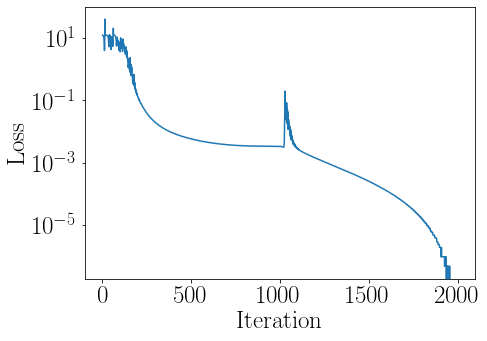

In [34]:
plt.rcParams.update({'font.size': 14})
plt.rc('text',usetex=True)
#font = {'family':'serif','size':16}
font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
plt.rc('font',**font)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
rc('text', usetex=True)
for i in range(1): 
    Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots(figsize=(7,5))
    ax.plot(Loss_history - np.min(Loss_history), '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    # ax.set_title("U/t = {}".format(U_train))
    ax.set_yscale('log')
    
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration")
    # ax.set_ylabel("Dot product")
    # ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    plt.savefig('/content/drive/MyDrive/DNN/figures/loss_M{}N{}n{}.pdf'.format(M,N,range(min_state, max_state)[i]), format='pdf',bbox_inches='tight')
    plt.show()
    

In [35]:
E_all = np.zeros(( len(U_train), model.tot_states) )
# check solution 
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_all[i] = evals

<ipython-input-35-ce8b16fb9a7f>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  E_all[i] = evals


In [36]:
U_test = np.linspace(1.5, 9.5, 20)
mu_test = np.zeros_like(U_test)


E_train, wf_gs = wf_e_calc(model_list[0], N_list[0], U_train, mu_train, t, V, 0, 0, fc1, use_gpu=True)
E_test, wf_gs_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


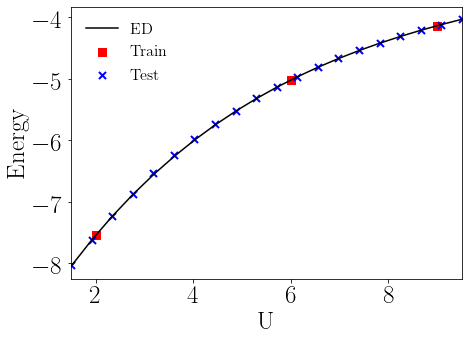

In [37]:
plt.rcParams.update({'font.size': 20})
plt.rc('text',usetex=True)
#font = {'family':'serif','size':16}
font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
plt.rc('font',**font)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(U_train,E_train,s=50,c='r', marker='s',label='Train')
ax.scatter(U_test,E_test,s=50, c='b', marker='x',label='Test',lw=2)

arr = [] 
for (i, U) in enumerate(U_test):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    arr.append(vals[0])
ax.plot(U_test,arr,'k',label='ED')
ax.set_xlim([min(U_test), max(U_test)])  
ax.set_ylabel('Energy')
ax.set_xlabel('U')
plt.legend(frameon=False,prop={'size': 16})
plt.savefig("/content/drive/MyDrive/DNN/figures/energy_M{}N{}.pdf".format(M,N), format='pdf',bbox_inches='tight')
plt.show()



<ipython-input-49-5723285bbbb9>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,i] = vals
<ipython-input-49-5723285bbbb9>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,i] = vecs


0


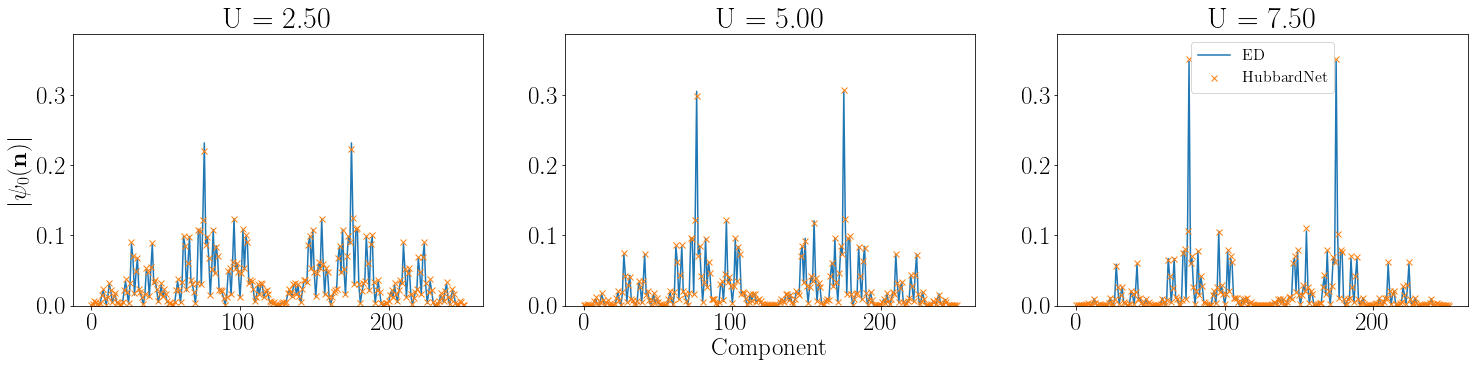

In [49]:
# rearrange states by symmetry 
all_states = np.zeros_like(model.all_states)
idx_list = np.zeros(model.tot_states,dtype=int)

for i in range(int(model.tot_states/2)): 
    all_states[i] = model.all_states[i]
    all_states[-i-1] = np.flip(model.all_states[i])
    idx_list[i] = i
    for j in range(model.tot_states):
        if all(model.all_states[j]==all_states[-i-1]): 
            idx_list[-i-1] = j
            break

# check wavefunctions 
U_test = np.array( [2.5, 5, 7.5] ) 
mu_test = np.zeros(len(U_test))
vals_all = np.zeros((model.tot_states, len(U_test)))
vals_idx_all = np.zeros_like(vals_all)
vecs_all = np.zeros((model.tot_states, model.tot_states, len(U_test)))

for (i,U) in enumerate(U_test):
    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx_all[:,i] = np.argsort(vals)
    vals_all[:,i] = vals
    vecs_all[:,:,i] = vecs

E_test, wf_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)


for s in range(0,max_state): 
    print(s)
    fig, ax = plt.subplots(1, len(U_test), figsize=(25, 5)) # for paper, figsize (20, 5) for 1D (25, 5) for 2D
    
    ymax = torch.max(wf_test[:,s]).detach().cpu().numpy()*1.1
    ymin = 0
    n_list = np.zeros( (len(U_test),M) )

    for (i,U) in enumerate(U_test):
    
        wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()

        # calculate occupation numbers
        for m_idx in range(M):
            for state_idx in range(model.tot_states):
                ci = wf_here[state_idx].cpu().detach().numpy()
                ni = model.all_states[state_idx][m_idx]
                n_list[i,m_idx] += ci**2 * ni

        wf_exact = np.abs(vecs_all[:,int(vals_idx_all[s, i]), i]).squeeze()
        wf_nn = np.abs(wf_here.cpu().detach().numpy())
        ax[i].plot(wf_exact[idx_list], label="ED")
        ax[i].plot(wf_nn[idx_list], 'x', label="HubbardNet")
        
        ax[i].set_title("U = {0:.2f}".format(U))
        ax[i].set_ylim((ymin,ymax))
    ax[0].set_ylabel('$|\psi_0 (\mathbf{n})|$')
    # ax[0].set_xlabel('Component')
    ax[1].set_xlabel('Component')
    ax[2].legend(frameon=True, prop={'size': 16})
    plt.savefig("/content/drive/MyDrive/DNN/figures/wf_M{}N{}_n{}_nexcited_{}.pdf".format(M,N,s,n_excited), format='pdf',bbox_inches='tight')
    plt.show()
    




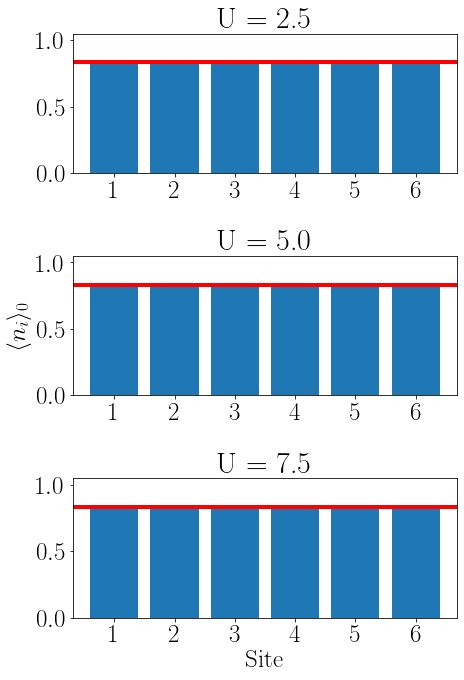

In [48]:
xgrid, ygrid = np.meshgrid(np.arange(w)+1, np.arange(h)+1)
xgrid = xgrid.ravel()
ygrid = ygrid.ravel()

if h == 1: # 1D
    fig, ax = plt.subplots(len(U_test),1,figsize=(7,10))
    for i, U in enumerate(U_test): 
        ax[i].bar(xgrid,n_list[i,:])
        ax[i].set_title("U = {0:.1f}".format(U))
        ax[i].set_xticks(xgrid)
        ax[i].axhline( N/M, linewidth=4, color='r', linestyle='-')
        ax[i].set_ylim([0,1.05])
        ax[i].set_yticks([0,0.5,1])

    ax[i].set_xlabel('Site')
    ax[1].set_ylabel(r'$ \langle n_i \rangle_0 $')
    plt.tight_layout()

else: # 2D 
    idx=2
    fig, ax = plt.subplots(figsize=(7,7))
    im=plt.pcolormesh(np.reshape(n_list[idx,:],(h,w)),cmap='coolwarm')
    ax.grid(True, color="k", lw=1)
    cbar=plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label(r'$\langle n_i \rangle_0 $')
    ax.set_aspect('equal')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xticks(np.arange(w))
    plt.yticks(np.arange(h))
    plt.title('$U = {}$'.format(U_test[idx]))
    plt.tight_layout()
      
plt.savefig("/content/drive/MyDrive/DNN/figures/occupation_M{}N{}U{}.pdf".format(M,N,U), format='pdf',bbox_inches='tight')
plt.show()
